In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import koopman_dir as km
from load_dataset import *
import argparse
import os
import yaml
import matplotlib.pyplot as plt

['/home/shiqi/code/model_combination_Argos/combined_network_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [3]:
import yaml

config_path = 'config_linear_1000_20.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
save_dir = config['save_dir']
data_dir = config['data_dir']
train_loss = np.load(save_dir + 'train_losses.npy')
test_loss = np.load(save_dir + 'test_losses.npy')

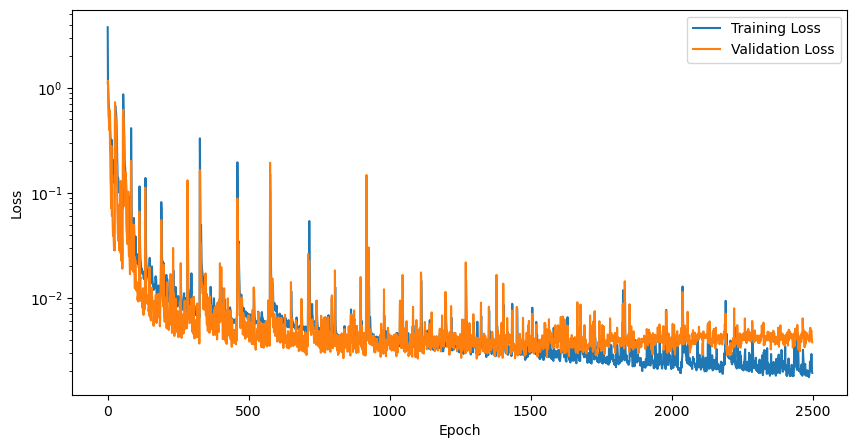

In [5]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

# Load data
nu = config['nu']
nu_list = [nu]
train_dataset, test_dataset, x_dim, u_dim = data_preparation_koopman(config, nu_list, nu)

# Set params
params = km.Params(x_dim = x_dim, u_dim = u_dim, config = config)

# Model
model = km.BuildModelFromParams(params).to(device)


cpu


In [7]:
model = torch.load(save_dir + 'model.pth').to(device)

In [8]:

# Data preparation
x_dataset = []
u_dataset = []
window_size = 150


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[:window_size,:])
        u_dataset.append(u_data[:window_size,:])
    else:
        print(f"File not found: {data_file_path}")

In [9]:
len(x_dataset)

49

In [10]:
# start from the zero point
nu = torch.tensor([1000])
x_data_pred_traj = []
nu = torch.tensor(build_nu(nu_list, 1, nu), dtype=torch.int16)
nu = nu.reshape((1, 1, -1))
for x_data, u_data in zip(x_dataset, u_dataset):
    steps = window_size
    
    x_data_scaled = scaler_x.transform(x_data)
    u_data_scaled = scaler_u.transform(u_data)
    x_data_scaled = torch.tensor(x_data_scaled, dtype = torch.float32)
    u_data_scaled = torch.tensor(u_data_scaled, dtype = torch.float32)
    x_data_scaled = x_data_scaled.reshape((1, window_size, -1))
    u_data_scaled = u_data_scaled.reshape((1, window_size, -1))
    

    x_data_latent = model.encode_state(x_data_scaled)
    x_data_latent_predicted = torch.zeros_like(x_data_latent)
    x_data_latent_predicted[:, 0, :] = x_data_latent[:, 0, :]
    for step in range(1, steps):
        # print(step)
       
        x = x_data_latent_predicted[:, step-1:step, :]
        # print(x)
        u = u_data_scaled[:, step-1:step, :]
        x_pred = model.forward_latent_to_latent(x, u, nu)
        x_data_latent_predicted[:, step:step+1, :] = x_pred
        # print(x_pred)
    x_data_pred_scaled = model.decode_state(x_data_latent_predicted).detach().numpy()
    x_data_pred_scaled = x_data_pred_scaled.reshape((window_size, -1))
    x_data_pred = scaler_x.inverse_transform(x_data_pred_scaled)
    x_data_pred_traj.append(x_data_pred)
    # break


In [11]:
x_data_pred_scaled = model.decode_state(x_data_latent_predicted).detach().numpy()
print(x_data_pred_scaled.shape)
print(x_data_pred.shape)
print(x_data.shape)

(1, 150, 6957)
(150, 6957)
(150, 6957)


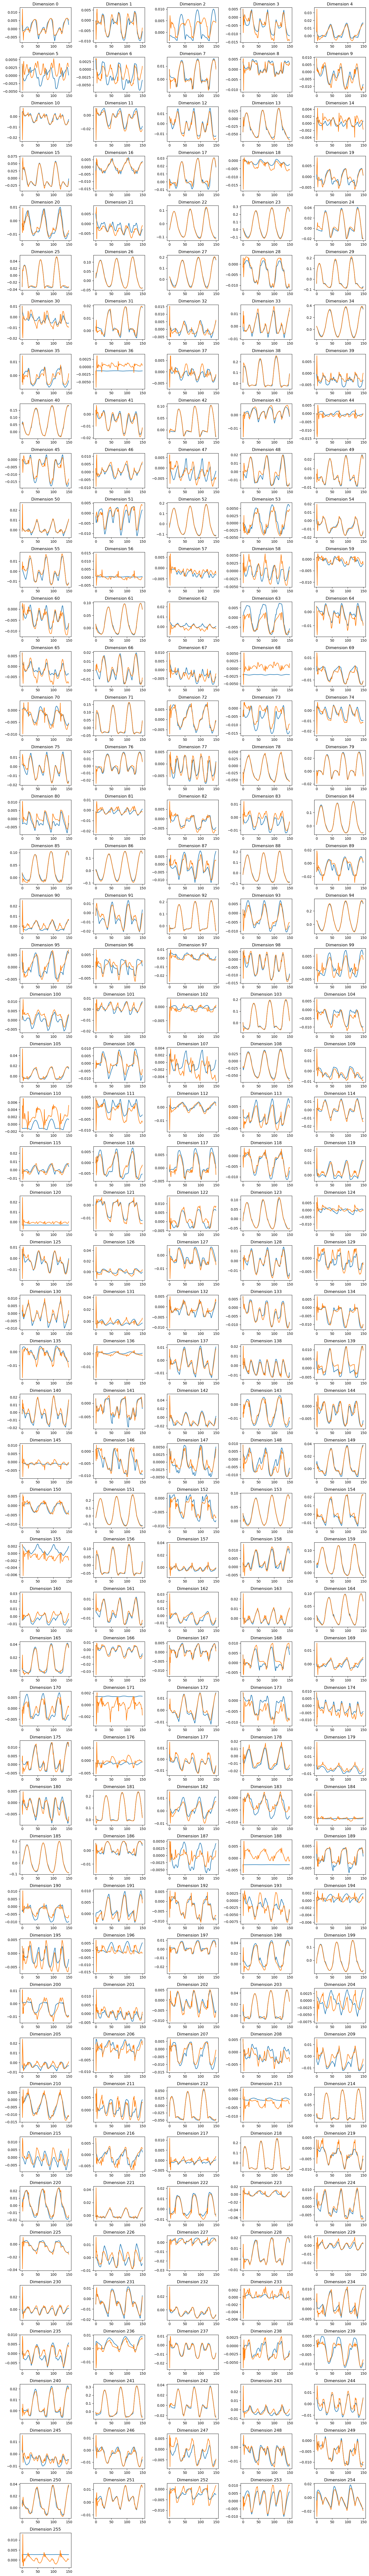

In [35]:
# latent dynamics

import numpy as np
import matplotlib.pyplot as plt

n_dim_latent = x_data_latent.shape[2]

n_cols = 5
n_rows = (n_dim_latent + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2))

axes_flat = axes.flatten()

for i in range(n_dim_latent):
    ax = axes_flat[i]
    
    ax.plot(x_data_latent.detach().numpy()[0, :, i], label = 'true')
    ax.plot(x_data_latent_predicted.detach().numpy()[0, :, i], label = 'pred')
    
    ax.set_title(f'Dimension {i}')
    # ax.legend()

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

6957


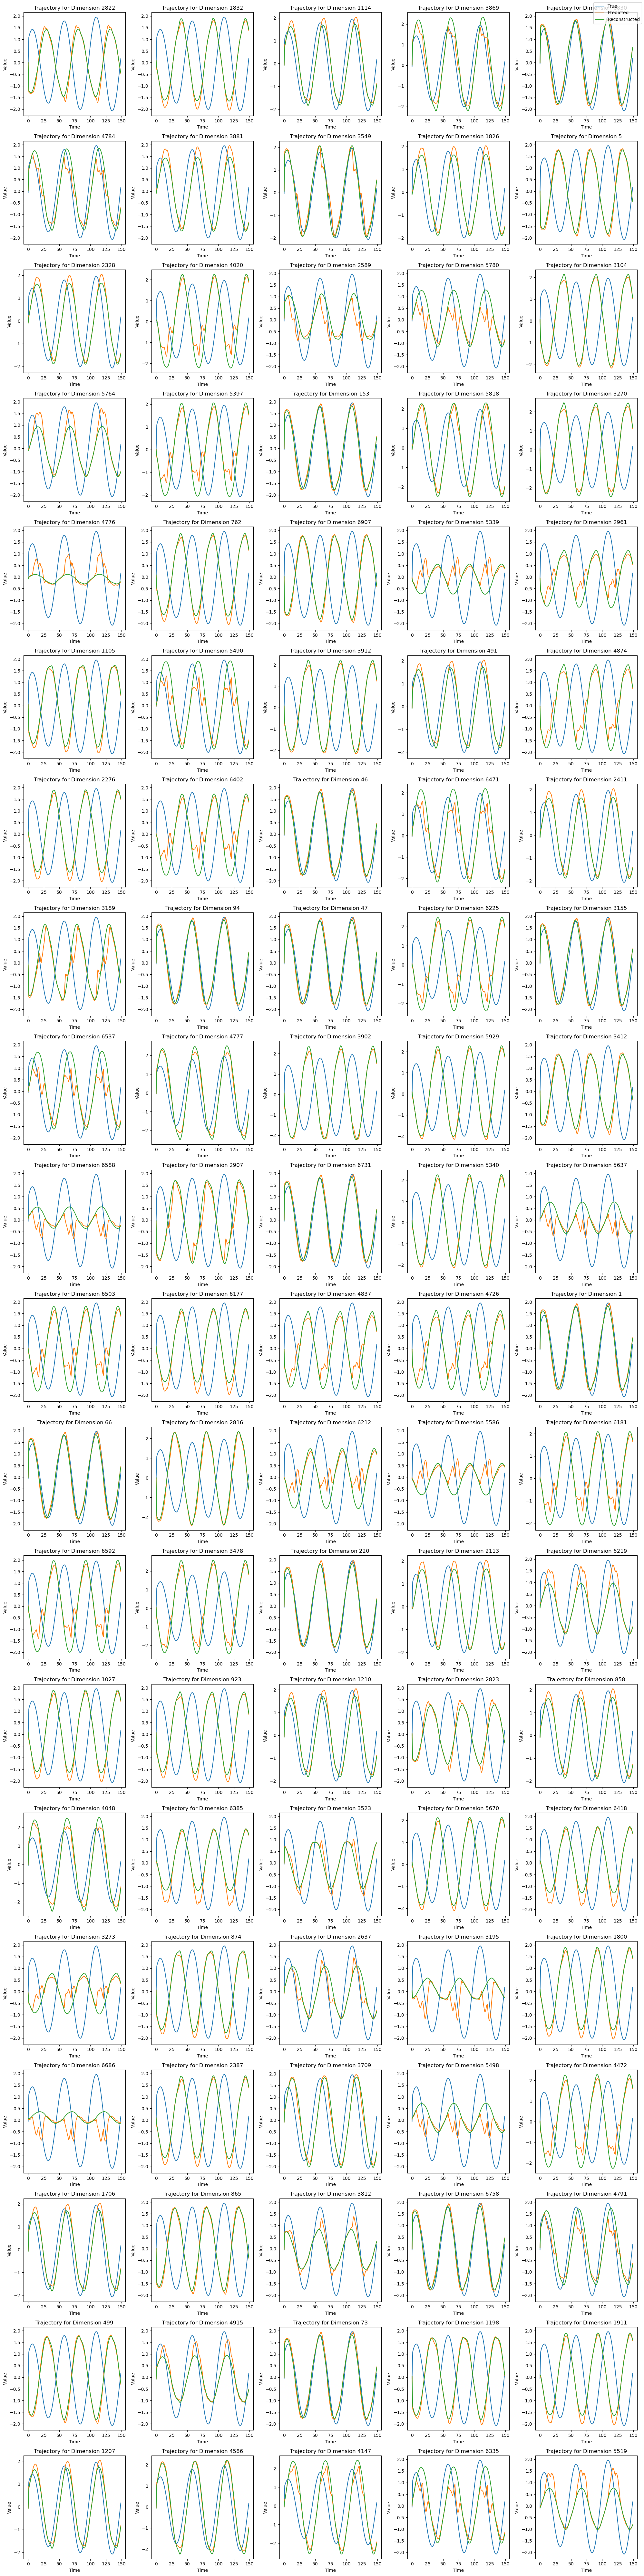

In [38]:
# scaled dynamics

import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_data_pred_scaled.shape[2]
print(n_dimensions)
selected_dimensions = np.random.choice(n_dimensions, 100, replace=False)
x_data_autoencoder = model.decode_state(x_data_latent).detach().numpy()


n_cols = 5
n_rows = len(selected_dimensions) // n_cols + (1 if len(selected_dimensions) % n_cols > 0 else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))  # Adjust figsize to fit display requirements

if n_rows == 1 or n_cols == 1:
    axes = np.array([axes])

axes_flat = axes.flatten()

for idx, dim in enumerate(selected_dimensions):
    ax = axes_flat[idx]
    line1, = ax.plot(x_data_scaled.detach().numpy()[0, :, i], label='True')
    line2, = ax.plot(x_data_pred_scaled[0, :, dim], label='Predicted')
    line3, = ax.plot(x_data_autoencoder[0, :, dim], label='Reconstructed')
    ax.set_title(f'Trajectory for Dimension {dim}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    # ax.legend()

fig.legend(handles=[line1, line2, line3], labels=['True', 'Predicted', 'Reconstructed'], loc='upper right')

for i in range(idx + 1, len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

In [39]:
# # Original dynamics

# import numpy as np
# import matplotlib.pyplot as plt

# n_dimensions = x_data_pred.shape[1]
# # selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# # selected_dimensions[-1] = 3229
# # selected_dimensions = range(10)

# for i in selected_dimensions:
#     plt.figure()
    
#     plt.plot(x_data[:, i], label = 'true')
#     plt.plot(x_data_pred[:, i], label = 'pred')
#     plt.title(f'Trajectory for Dimension {i}')
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()

In [40]:
errors = [x_data_pred_traj[i] - x_dataset[i][:window_size, :] for i in range(len(x_data_pred_traj))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [41]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

In [42]:
# np.where(np.array(relative_errors)[:, -1]>0.03)

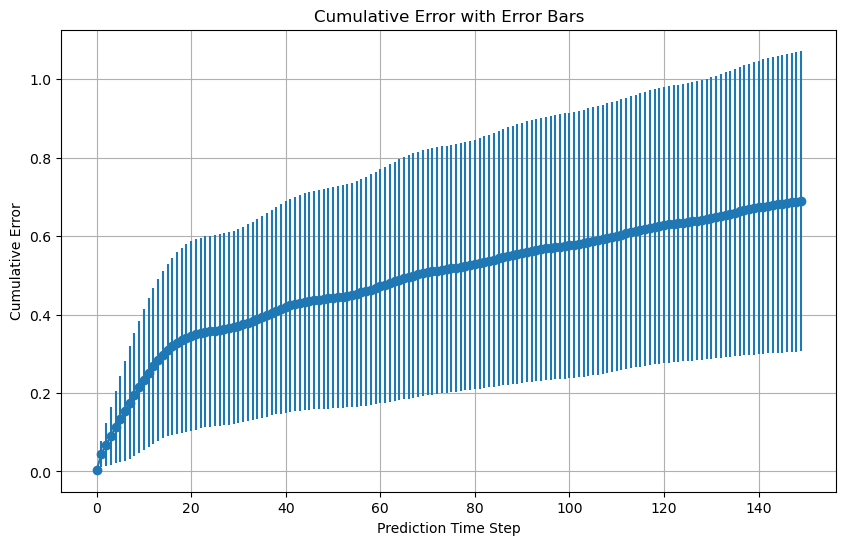

In [43]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(window_size), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
# plt.ylim(0, 0.15)
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [44]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [45]:
np.mean(domain_relative_error)

0.6894965326440678

In [46]:
np.std(domain_relative_error)

0.3833430918511838

In [47]:
x_dataset[0].shape

(150, 6957)

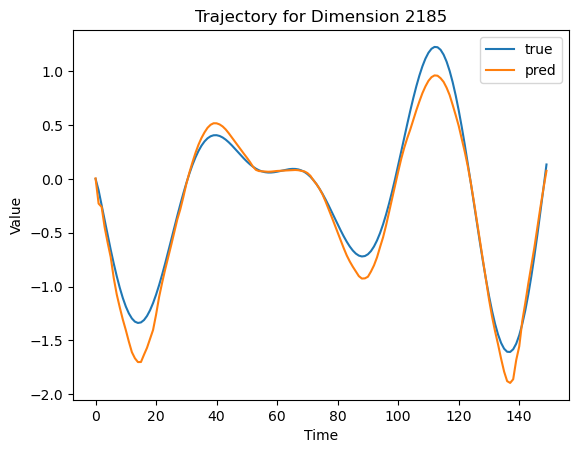

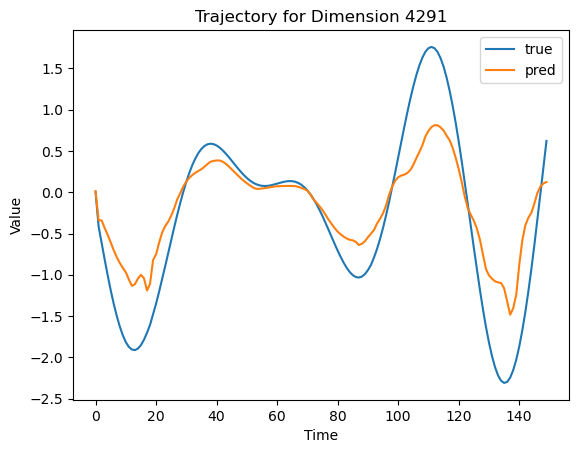

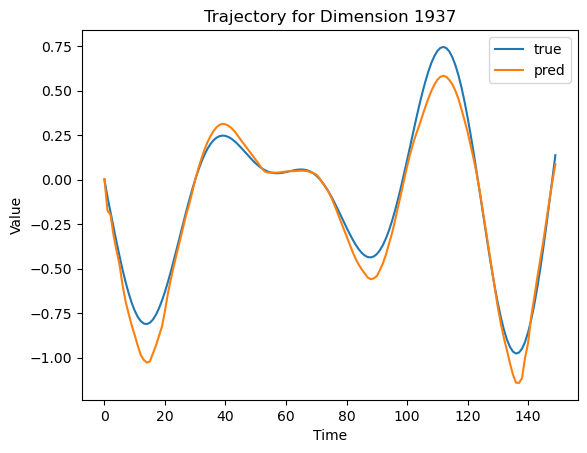

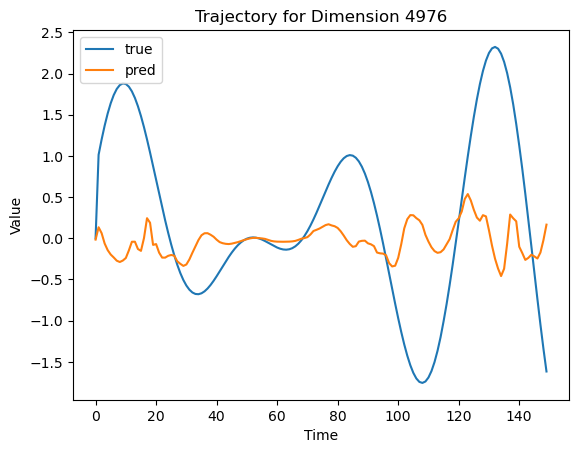

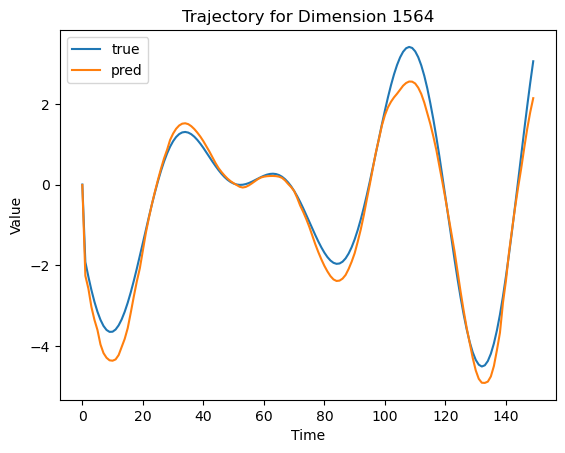

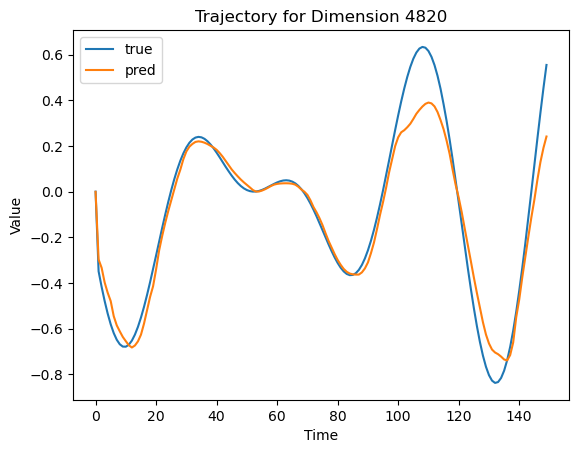

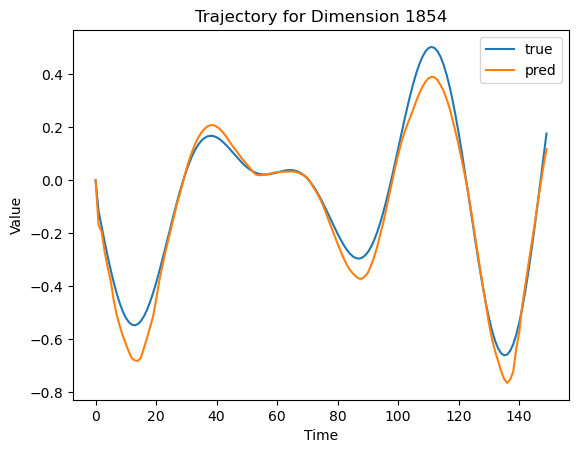

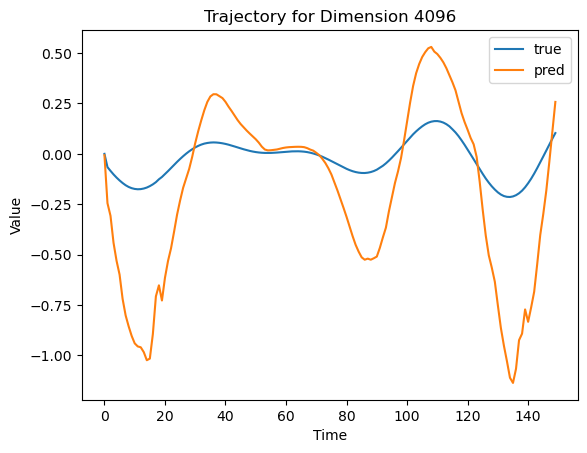

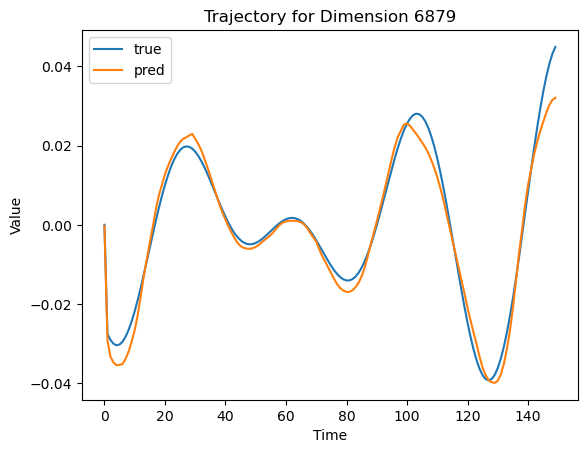

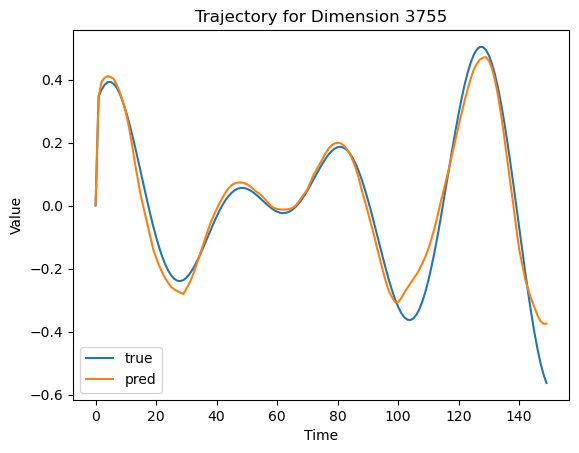

In [48]:
import numpy as np
import matplotlib.pyplot as plt
k=0
n_dimensions = x_dataset[k].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# selected_dimensions[-1] = 3229
# selected_dimensions = range(10)

for i in selected_dimensions:
    plt.figure()
    x_true = x_dataset[k]
    x_pred = x_data_pred_traj[k]
    plt.plot(x_true[:, i], label = 'true')
    plt.plot(x_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [49]:
errors = [x_data_pred_traj[i] - x_dataset[i][:, :] for i in range(len(x_data_pred_traj))]

ratios_all = np.zeros((len(errors), 6957))

for i in range(len(errors)):
    reference = x_dataset[i][:window_size, :]
    error = errors[i]
    reference_norms = np.linalg.norm(reference, axis=0)
    error_norms = np.linalg.norm(error, axis=0)
    # print(error_norms)
    ratios_all[i] = error_norms / reference_norms

# 计算平均比值和标准差
mean_ratios = np.mean(ratios_all, axis=0)
std_ratios = np.std(ratios_all, axis=0)

mean_ratios, std_ratios

(array([0.14133851, 0.14152987, 0.14133522, ..., 0.14700755, 0.14650878,
        0.1454481 ]),
 array([0.08038515, 0.08046394, 0.08038319, ..., 0.08396908, 0.08365886,
        0.08301144]))

In [50]:
ratios_all[0]

array([0.17610533, 0.17629037, 0.17610254, ..., 0.18120979, 0.18066172,
       0.17969499])

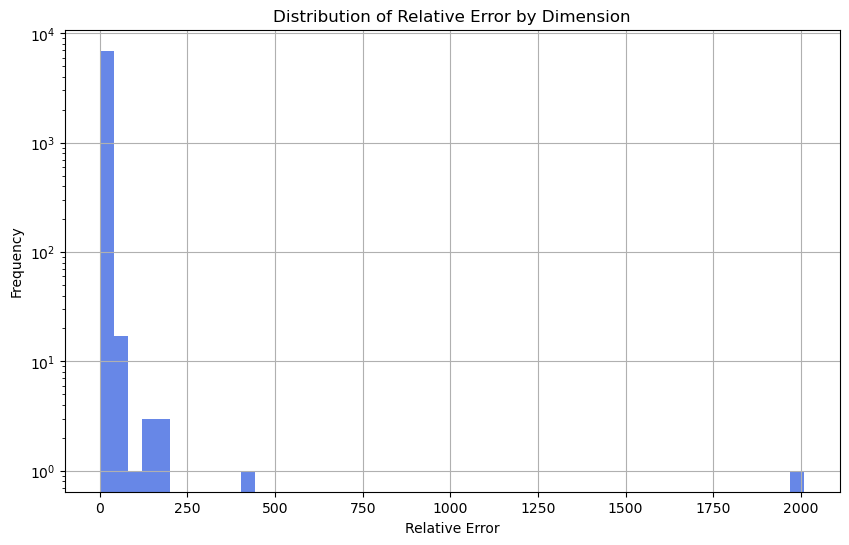

In [51]:
plt.figure(figsize=(10, 6))
plt.hist(mean_ratios, bins=50, alpha=0.8, color='royalblue')
plt.title('Distribution of Relative Error by Dimension')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

In [52]:
max(mean_ratios)

2010.3054018079893

In [53]:
# mean_value = np.mean(mean_ratios)
# print(mean_value)
# count_above_mean = np.sum(mean_ratios > 0.2)
# count_above_mean

In [54]:
# indexes_large_error = np.where(mean_ratios > 0.5)
# indexes_large_error

In [55]:
# idx = 39
# n_dimensions = x_dataset[idx].shape[1]
# selected_dimensions = indexes_large_error[0]

# for i in selected_dimensions[0:10]:
#     plt.figure()
#     y_true = x_dataset[idx]
#     y_pred = y_data_pred_50traj_10predict[idx]
#     plt.plot(y_true[:, i], label = 'true')
#     plt.plot(y_pred[:, i], label = 'pred')
#     plt.title(f'Trajectory for Dimension {i}')
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()